In [16]:
import pandas as pd
import numpy as np
# 1) Load
df = pd.read_excel(r"C:\Users\62853\Downloads\Fintech\combined_credit_dataset_optionB.xlsx")
df.head()


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,REGION_RATING_CLIENT,NAME_HOUSING_TYPE,...,int_rate,monthly_payment,annual_inc,total_dti,bnpl_default,payment_burden,txn_count,avg_amount,txn_amount_variance,fraud_rate
0,103500.0,625536.0,26631.0,0,1,Secondary / secondary special,Working,NaN,1,Municipal apartment,...,11.99,1328.39,109000.0,11.37,0,0.012187,7,149736.420000,1.095982e+10,0.000000
1,202500.0,292500.0,14625.0,0,1,Higher education,Commercial associate,Sales staff,2,House / apartment,...,13.67,415.76,46000.0,25.20,0,0.009038,1,585.590000,NaN,0.000000
2,247500.0,1442596.5,46665.0,0,2,Secondary / secondary special,Commercial associate,NaN,1,House / apartment,...,6.71,1076.07,80000.0,7.97,0,0.013451,209,86849.575550,1.431328e+10,0.043062
3,270000.0,545040.0,26509.5,0,2,Secondary / secondary special,Commercial associate,Security staff,1,House / apartment,...,8.39,286.49,104000.0,11.24,0,0.002755,17,51593.672941,4.865902e+09,0.058824
4,450000.0,540000.0,56835.0,0,2,Higher education,Working,Managers,2,House / apartment,...,14.47,1204.23,100000.0,12.26,0,0.012042,27,114344.592593,9.683312e+09,0.111111


# Data Cleaning

In [17]:
import pandas as pd
import numpy as np
import re

# --- 1) parse loan_term (object) ->number of months (float) ---
def parse_loan_term_to_months(s):
    if pd.isna(s):
        return np.nan
    t = str(s).strip().lower()
    # remove comma & double spacing
    t = t.replace(',', ' ').strip()

    # ambil angka & unit (opsional)
    m = re.search(r'(?P<num>\d+(\.\d+)?)\s*(?P<unit>years?|yrs?|y|months?|mos?|m|weeks?|w|days?|d)?', t)
    if not m:
        # fallback: kalau murni angka tanpa unit, anggap bulan
        try:
            return float(t)
        except:
            return np.nan

    num = float(m.group('num'))
    unit = m.group('unit') or 'm'  # default: bulan

    # konversi ke bulan
    if unit.startswith(('year', 'yr', 'y')):
        return num * 12.0
    elif unit.startswith(('month', 'mo', 'm')):
        return num
    elif unit.startswith(('week', 'w')):
        # 1 bulan ≈ 4.345 minggu
        return num / 4.345
    elif unit.startswith(('day', 'd')):
        # 1 bulan ≈ 30.44 hari
        return num / 30.44
    else:
        # unit tak dikenal → asumsi bulan
        return num

# Terapkan ke kolom
df_clean = df.copy()  # pakai frame kerjamu
df_clean['loan_term'] = df_clean['loan_term'].apply(parse_loan_term_to_months)

# Paksa kolom numerik lain yang “terformat teks” agar benar-benar numerik
force_numeric = [
    'int_rate','monthly_payment','annual_inc','total_dti','payment_burden',
    'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AGE','EMPLOYMENT_YEARS',
    'credit_to_income_ratio','annuity_to_income_ratio',
    'txn_count','avg_amount','txn_amount_variance','fraud_rate','TARGET'
]
for c in force_numeric:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

# --- 2) pisahkan numerik & kategorikal yang kamu inginkan ---
numeric_cols = df_clean.select_dtypes(include='number').columns.tolist()

categorical_cols = [
    'NAME_EDUCATION_TYPE',
    'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE',
    'NAME_HOUSING_TYPE',
    'NAME_FAMILY_STATUS',
    # tambahkan ini jika kamu ingin perlakukan sebagai kategori meski numeric-coded:
    # 'REGION_RATING_CLIENT'
]

# --- 3) winsorize hanya numerik ---
df_winsor_num = df_clean[numeric_cols].copy()
for col in numeric_cols:
    lo, hi = df_winsor_num[col].quantile([0.01, 0.99])
    df_winsor_num[col] = np.clip(df_winsor_num[col], lo, hi)

# --- 4) gabungkan kembali dengan kategori ---
df_cat = df_clean[categorical_cols].copy()
df_final = pd.concat([df_winsor_num.reset_index(drop=True),
                      df_cat.reset_index(drop=True)], axis=1)

df_final.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,TARGET,AGE,EMPLOYMENT_YEARS,credit_to_income_ratio,...,payment_burden,txn_count,avg_amount,txn_amount_variance,fraud_rate,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,OCCUPATION_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS
0,103500.0,625536.0,26631.0,0,1,1,0,40.9,10.5,6.043826,...,0.012187,7.0,149736.420000,1.095982e+10,0.000000,Secondary / secondary special,Working,NaN,Municipal apartment,Single / not married
1,202500.0,292500.0,14625.0,0,1,2,0,42.4,1.9,1.444444,...,0.009038,1.0,585.590000,NaN,0.000000,Higher education,Commercial associate,Sales staff,House / apartment,Single / not married
2,247500.0,1442596.5,46665.0,0,2,1,0,42.7,0.9,5.828673,...,0.013451,209.0,86849.575550,1.431328e+10,0.043062,Secondary / secondary special,Commercial associate,NaN,House / apartment,Civil marriage
3,270000.0,545040.0,26509.5,0,2,1,0,44.9,8.3,2.018667,...,0.002755,17.0,51593.672941,4.865902e+09,0.058824,Secondary / secondary special,Commercial associate,Security staff,House / apartment,Civil marriage
4,450000.0,540000.0,56835.0,0,2,2,0,30.0,11.0,1.200000,...,0.012042,27.0,114344.592593,9.683312e+09,0.111111,Higher education,Working,Managers,House / apartment,Married


In [18]:
df_final = df_final.dropna().copy()

In [19]:
df_model = pd.get_dummies(df_final, columns=categorical_cols, drop_first=True)

# convert True/False → 0/1
df_model = df_model.astype(int)
df_model.head()


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,TARGET,AGE,EMPLOYMENT_YEARS,credit_to_income_ratio,...,OCCUPATION_TYPE_Waiters/barmen staff,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
3,270000,545040,26509,0,2,1,0,44,8,2,...,0,1,0,0,0,0,0,0,0,0
4,450000,540000,56835,0,2,2,0,30,11,1,...,0,1,0,0,0,0,1,0,0,0
8,180000,540000,27000,1,3,2,0,48,4,3,...,0,1,0,0,0,0,1,0,0,0
9,202500,584766,23319,0,2,3,0,54,3,2,...,0,1,0,0,0,0,1,0,0,0
10,162000,187704,10903,2,4,2,0,39,10,1,...,0,1,0,0,0,0,1,0,0,0


# Build ML Model

In [20]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Data
X = df_model.drop(columns=['TARGET'])
y = df_model['TARGET']

# Scaling for ANN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), 
                                          activation='relu', 
                                          solver='adam', 
                                          max_iter=300)
}

results = []

# Run 5 experiments
for experiment in range(1, 6):
    print(f"=== Experiment {experiment} ===")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=experiment, stratify=y
    )

    # Scaled version for ANN
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    kf = KFold(n_splits=5, shuffle=True, random_state=experiment)

    for model_name, model in models.items():
        
        start = time.time()

        # Use scaled data for ANN, raw for others
        if model_name == "Neural Network (MLP)":
            cv_auc = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='roc_auc')
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:,1]
        else:
            cv_auc = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:,1]

        end = time.time()

        results.append({
            "Experiment": experiment,
            "Model": model_name,
            "CV AUC Mean": cv_auc.mean(),
            "CV AUC Std": cv_auc.std(),
            "Test AUC": roc_auc_score(y_test, y_prob),
            "Test Accuracy": accuracy_score(y_test, y_pred),
            "Test F1": f1_score(y_test, y_pred),
            "Training Time (s)": round(end - start, 3)
        })

results_df = pd.DataFrame(results)
results_df


=== Experiment 1 ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 512, number of negative: 4976
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 5488, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093294 -> initscore=-2.274057
[LightGBM] [Info] Start training from score -2.274057
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 492, number of negative: 4996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

,Experiment,Model,CV AUC Mean,CV AUC Std,Test AUC,Test Accuracy,Test F1,Training Time (s)
0,1,Logistic Regression,0.543120,0.025691,0.503342,0.909674,0.000000,0.319
1,1,Decision Tree,0.508296,0.006819,0.485607,0.804196,0.081967,0.571
2,1,Random Forest,0.598464,0.024097,0.617323,0.909674,0.000000,12.905
3,1,XGBoost,0.573881,0.010927,0.582844,0.906760,0.036145,1.489
4,1,LightGBM,0.599987,0.016466,0.605530,0.906177,0.000000,0.934
5,1,Neural Network (MLP),0.563839,0.012094,0.526544,0.838578,0.120635,49.561
6,2,Logistic Regression,0.537183,0.008740,0.529474,0.909674,0.000000,0.292
7,2,Decision Tree,0.509217,0.009656,0.501416,0.806527,0.107527,0.682
8,2,Random Forest,0.602028,0.016986,0.604003,0.909674,0.000000,12.831
9,2,XGBoost,0.606030,0.014162,0.569614,0.902098,0.023256,1.435


In [22]:
summary = results_df.groupby("Model")[["CV AUC Mean", "Test AUC", "Test F1", "Test Accuracy"]].mean()
summary.sort_values(by="Test AUC", ascending=False)


,CV AUC Mean,Test AUC,Test F1,Test Accuracy
Model,,,,
LightGBM,0.607500,0.607053,0.010079,0.908392
Random Forest,0.600428,0.595945,0.000000,0.909674
XGBoost,0.592398,0.579929,0.028512,0.905245
Neural Network (MLP),0.544491,0.559591,0.127561,0.851865
Logistic Regression,0.539401,0.521890,0.000000,0.909674
Decision Tree,0.510073,0.506669,0.112793,0.816084


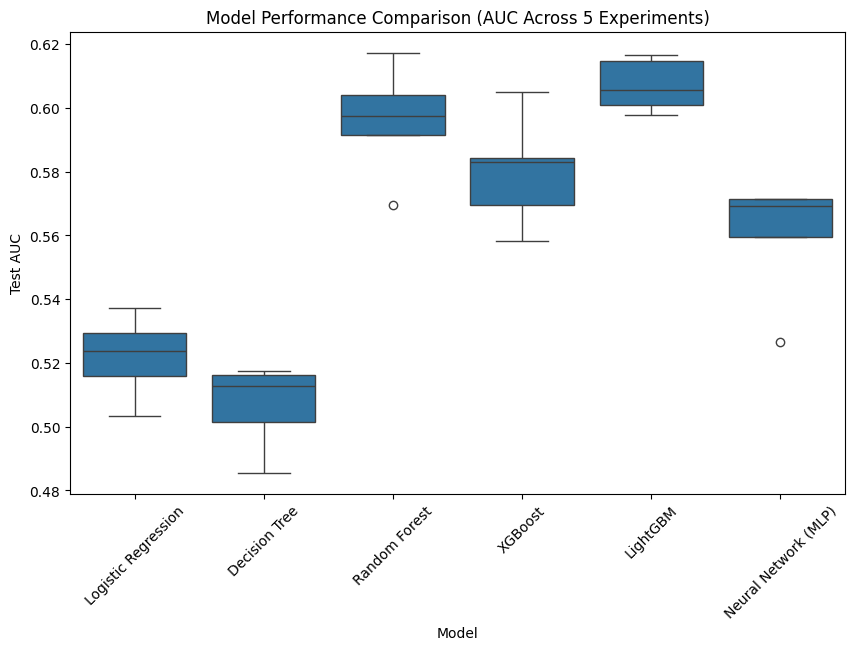

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=results_df, x="Model", y="Test AUC")
plt.xticks(rotation=45)
plt.title("Model Performance Comparison (AUC Across 5 Experiments)")
plt.show()


# Run the selected model, calculate credit score and re-group the target

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import numpy as np
import pandas as pd

# === 1) Split Data ===
X = df_model.drop(columns=['TARGET'])
y = df_model['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 2) Train Class-Weighted Random Forest ===
rf_balanced = RandomForestClassifier(
    n_estimators=250,
    max_depth=None,              
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",     
    n_jobs=-1,
    random_state=42
)

rf_balanced.fit(X_train, y_train)

# === 3) Predict Probability of Default (PD) ===
# RandomForest supports predict_proba
y_prob = rf_balanced.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_prob))

# === 4) Find Optimal Threshold Using F1 ===
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)   # avoid zero division

# thresholds maps to points 1..end; align by skipping f1_scores[0]
best_index = np.argmax(f1_scores[1:])
best_threshold = thresholds[best_index]
best_f1 = f1_scores[1:][best_index]

print("\nBest Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

# === 5) Apply New Threshold ===
y_pred_adjusted = (y_prob >= best_threshold).astype(int)

print("\nAdjusted Classification Report:\n")
print(classification_report(y_test, y_pred_adjusted, digits=4))

print("\nAdjusted Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_adjusted))


AUC: 0.6143373767849394

Best Threshold: 0.112
Best F1 Score: 0.20554611482123586

Adjusted Classification Report:

              precision    recall  f1-score   support

           0     0.9276    0.7226    0.8124      1561
           1     0.1340    0.4323    0.2046       155

    accuracy                         0.6964      1716
   macro avg     0.5308    0.5774    0.5085      1716
weighted avg     0.8559    0.6964    0.7575      1716


Adjusted Confusion Matrix:

[[1128  433]
 [  88   67]]


# Predict the target variable using the best model

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 0) Ensure clean feature names (fixes whitespace issues)
X = df_model.drop(columns=['TARGET']).copy()
X.columns = X.columns.str.replace(r'\s+', '_', regex=True)
y = df_model['TARGET'].copy()

# 1) Train/test split (keep for reporting; we’ll also score ALL rows)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Train class-weighted Random Forest
rf_balanced = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,           # or set (e.g., 12–20) to reduce overfitting
    max_features="sqrt",
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_balanced.fit(X_train, y_train)

# 3) Score ALL rows (PD = probability of default)
pd_all = rf_balanced.predict_proba(X)[:, 1]

# 4) Convert PD -> Score (300–850)
score_all = 850 - (pd_all * 550)

# 5) Categorize using your tuned threshold for classification
# NOTE: Thresholds are model-specific; ideally re-tune for RF.
best_threshold = 0.32206125134895747  # from previous search

def score_to_category(score):
    if score >= 700:
        return "GOOD"
    elif score >= 550:
        return "STANDARD"
    else:
        return "POOR"

risk_category = np.vectorize(score_to_category)(score_all)

# 6) Build final scored table
scored_all = X.copy()
scored_all['TARGET'] = y.values
scored_all['PD'] = pd_all
scored_all['Score'] = score_all.round().astype(int)
scored_all['Risk_Category'] = risk_category
scored_all['Pred_Default_(thresholded)'] = (pd_all >= best_threshold).astype(int)

scored_all.head()


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,AGE,EMPLOYMENT_YEARS,credit_to_income_ratio,annuity_to_income_ratio,...,NAME_HOUSING_TYPE_With_parents,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single_/_not_married,NAME_FAMILY_STATUS_Widow,TARGET,PD,Score,Risk_Category,Pred_Default_(thresholded)
3,270000,545040,26509,0,2,1,44,8,2,0,...,0,0,0,0,0,0,0.013333,843,GOOD,0
4,450000,540000,56835,0,2,2,30,11,1,0,...,0,1,0,0,0,0,0.010000,844,GOOD,0
8,180000,540000,27000,1,3,2,48,4,3,0,...,0,1,0,0,0,0,0.023333,837,GOOD,0
9,202500,584766,23319,0,2,3,54,3,2,0,...,0,1,0,0,0,0,0.125000,781,GOOD,0
10,162000,187704,10903,2,4,2,39,10,1,0,...,0,1,0,0,0,0,0.073333,810,GOOD,0


In [25]:
# 7) Save
scored_all.to_excel("scored_dataset_randomforest_thresholded.xlsx", index=False)
print("Saved: scored_dataset_randomforest_thresholded.xlsx")

Saved: scored_dataset_randomforest_thresholded.xlsx


# Compute SHAP Value for Explainable AI

In [28]:
import shap
import numpy as np

#Step 1 — Create SHAP Explainer for Your Random Forest
# Create SHAP explainer for your trained model
explainer = shap.TreeExplainer(rf_balanced)

# Convert test features to numpy (SHAP works best with np arrays)
X_test_array = X_test.values
feature_names = list(X_test.columns)

# Compute SHAP values (this returns 2 arrays: class 0 and class 1)
shap_values = explainer.shap_values(X_test_array)

# We use the contribution for the **positive class** (default risk = 1)
shap_default = shap_values[1]


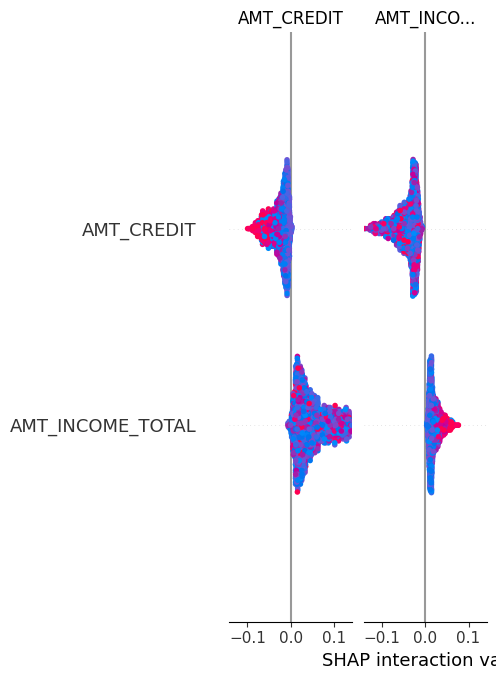

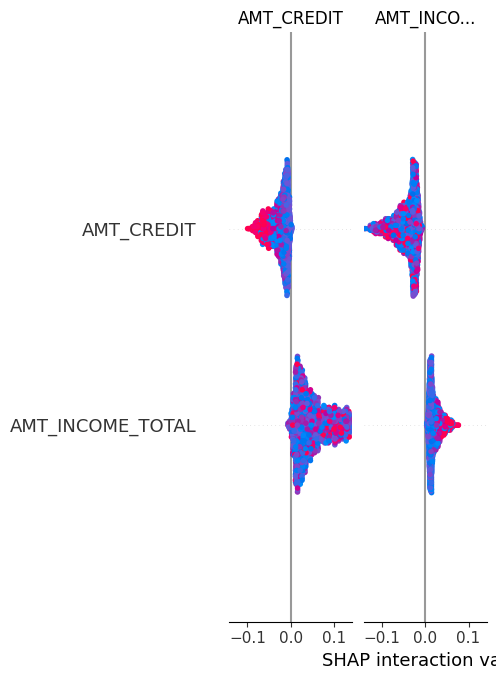

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (55, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [30]:
# --- Use the SAME features the model saw ---
# If you trained on dummified data, recreate and align exactly:
X_train_d = pd.get_dummies(X_train, drop_first=True)
X_test_d  = pd.get_dummies(X_test,  drop_first=True)
X_test_d  = X_test_d.reindex(columns=X_train_d.columns, fill_value=0)

# TreeExplainer for RandomForest
import shap, numpy as np
explainer = shap.TreeExplainer(rf_balanced)

# Compute SHAP on the dummified matrix
X_test_array = X_test_d.values
feature_names = list(X_test_d.columns)

shap_values = explainer.shap_values(X_test_array)
# pick positive class (assuming labels {0,1})
pos_idx = int(np.where(rf_balanced.classes_ == 1)[0][0]) if isinstance(shap_values, list) else None
shap_default = shap_values[pos_idx] if isinstance(shap_values, list) else shap_values

# Now shapes match: shap_default.shape[1] == X_test_array.shape[1]
# Global plots
shap.summary_plot(shap_default, X_test_array, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_default, X_test_array, feature_names=feature_names)

# Local waterfall example
exp = shap.Explanation(
    values = shap_default[0, :],
    base_values = explainer.expected_value[pos_idx] if isinstance(shap_values, list) else explainer.expected_value,
    data = X_test_array[0, :],
    feature_names = feature_names
)
shap.plots.waterfall(exp)


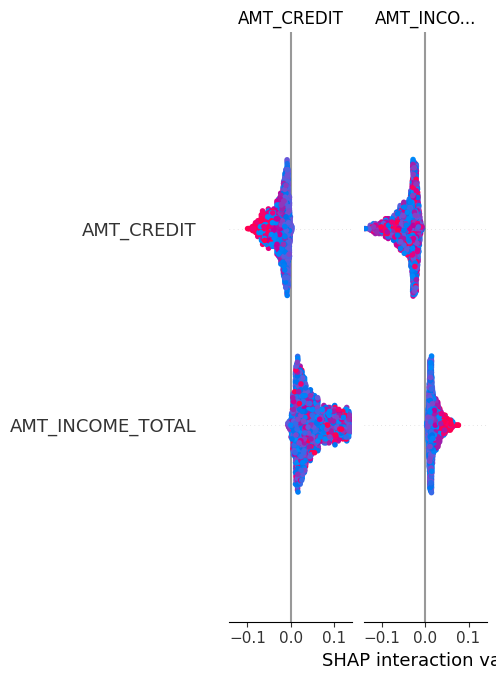

In [31]:
#Step 2 — Global Explanation (Model-Level)

#Feature Importance Bar Plot
#shap.summary_plot(shap_default, X_test_array, feature_names=feature_names, plot_type="bar")
#Beeswarm Plot (Impact + Direction)
shap.summary_plot(shap_default, X_test_array, feature_names=feature_names)


In [32]:
#Step 3 — Individual Explanation (Customer-Level XAI)
i = 0  # choose row index to explain

shap.plots.waterfall(shap.Explanation(
    values = shap_default[i,:],
    base_values = explainer.expected_value[1],
    data = X_test_array[i,:],
    feature_names = feature_names
))


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (55, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [33]:
#Step 4 — Convert SHAP into Reason Codes (For Dashboard / SMS / UI)
def shap_reason_codes(index, k=5):
    vals = shap_default[index]
    idx = np.argsort(np.abs(vals))[-k:][::-1]
    return [(feature_names[j], float(vals[j])) for j in idx]

print(shap_reason_codes(0))


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
#Step 5 — Individual Customer Explanation (Local Explanation)
i = 0
shap.force_plot(explainer.expected_value[1], shap_default[i,:], X_test_array[i,:], feature_names=feature_names)


In [ ]:
shap.plots.waterfall(shap.Explanation(
    values = shap_default[i,:],
    base_values = explainer.expected_value[1],
    data = X_test_array[i,:],
    feature_names = feature_names
))


In [ ]:
#If your model was trained in a Pipeline (scaler or encoding included):
from sklearn.pipeline import Pipeline

if isinstance(rf_balanced, Pipeline):
    model = rf_balanced.named_steps['rf']  # or whatever your RF step name is
    X_test_transformed = rf_balanced.named_steps['prep'].transform(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_transformed)
